# 최적화 알고리즘 실습
이 목차는 빈 칸이 없으니 전부 바로 실행하시고 코드 구성과 비교 흐름을 이해해보세요. 경우에 따라 실행 결과는 다르게 나올 수 있고, 여유가 된다면 학습률이나 여러 계수들을 조정하여 실험해보세요. 또한, 시각화된 그래프의 interactive 기능들을 사용하면, 확대 / 축소 / 돌리기 / 가리기 등이 가능합니다.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
def select_optim(model, lr, idx):
  optimizers = [torch.optim.SGD(model.parameters(), lr = lr, momentum=0),
                torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9),
                torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, nesterov=True),
                torch.optim.Adagrad(model.parameters(), lr = lr),
                torch.optim.RMSprop(model.parameters(), lr = lr, alpha=0.9),
                torch.optim.Adam(model.parameters(), lr = lr, betas=(0.9,0.999)),
                torch.optim.AdamW(model.parameters(), lr =lr, betas=(0.9,0.999), weight_decay=0.001)]
  return optimizers[idx]

In [3]:
def Navigating_f(x0 , y0 , n_steps = 30,
                 n_optimizers = 7, lr = 0.01):
  Xs, Ys = [], []
  for i in range(n_optimizers):
    # model & optimizer
    model = my_model(x0,y0).to(device)
    optimizer = select_optim(model, lr, i)

    X,Y = [],[]
    for step in range(n_steps):
      X.append(model.get_parameter('x').item())
      Y.append(model.get_parameter('y').item())
      optimizer.zero_grad()
      loss = model()
      loss.backward()
      optimizer.step()
    Xs.append(X)
    Ys.append(Y)
  return Xs, Ys

In [4]:
def Plotting_f(Xs, Ys, plot_range = 0.6, transpose = False,
               alpha = 0.5, R = 204, G = 204, B = 204):

  # Make scatter object
  scatters = []
  for c,(X,Y) in enumerate(zip(Xs, Ys)):
    Z = [my_function_np(X[i],Y[i]) for i in range(len(X))]
    df = pd.DataFrame({'x':X, 'y':Y, 'z':Z})
    scatter = go.Scatter3d(x = df.x,
                           y = df.y, 
                           z = df.z,
                           mode = "markers",
                           name = names[c],
                           marker = dict(size=[5]*len(df),
                                         sizemode='diameter',
                                         color = palette[c],
                                         line = dict(width = 0)))
    scatters.append(scatter)

  # Make surface object
  xs = np.linspace(-plot_range, plot_range,100)
  ys = np.linspace(-plot_range, plot_range,100)
  xx,yy = np.meshgrid(xs,ys)
  zz = my_function_np(xx,yy)
  if transpose:
    zz = zz.T
  cmap = 'rgba(%d,%d,%d,%f)'%(R,G,B,alpha)
  surface = go.Surface(x = xs, y = ys, z = zz,
                       colorscale = [[0, cmap], [1, cmap]],
                       showscale=False)

  fig = go.Figure([*scatters, surface])
  fig.show()

In [5]:
# color & label
palette = ['rgba(255, 0, 0, 1)',
           'rgba(255, 255, 0, 1)',
           'rgba(0, 255, 0, 1)',
           'rgba(0, 255, 255, 1)',
           'rgba(0, 0, 255, 1)',
           'rgba(255, 0, 255, 1)',
           'rgba(64, 64, 64, 1)']
names = ['SGD', 'Momentum', 'NAG', 'Adagrad',
         'RMSProp', 'Adam','AdamW']

## 시각화

In [6]:
# 함수 정의
def my_function(x,y):
  return 1*(x**2 - y**2)
def my_function_np(x,y):
  return 1*(x**2 - y**2)

# 모델 정의
class my_model(nn.Module):
  def __init__(self,x,y):
    super(my_model, self).__init__()
    self.x = nn.parameter.Parameter(data=torch.tensor(x, dtype = dtype), requires_grad=True)
    self.y = nn.parameter.Parameter(data=torch.tensor(y, dtype = dtype), requires_grad=True)

  def forward(self):
    return my_function(self.x, self.y)

# 시각화
Xs, Ys = Navigating_f(x0 = 0.5, y0 = 0.00001, n_optimizers = 7, n_steps = 30, lr = 0.01)
Plotting_f(Xs, Ys)

In [7]:
# 함수 정의
def my_function(x,y):
  return 0.01*(torch.exp(-(y+1)**2-x**2)*(x-1)**2 - torch.exp(-(x+1)**2-y**2)/3 + \
  torch.exp(-x**2-y**2)*(10*x**3-2*x+10*y**5))

def my_function_np(x,y):
  return 0.01*(np.exp(-(y+1)**2-x**2)*(x-1)**2 - np.exp(-(x+1)**2-y**2)/3 + \
  np.exp(-x**2-y**2)*(10*x**3-2*x+10*y**5))


# 모델 정의
class my_model(nn.Module):
  def __init__(self,x,y):
    super(my_model, self).__init__()
    self.x = nn.parameter.Parameter(data=torch.tensor(x, dtype = dtype), requires_grad=True)
    self.y = nn.parameter.Parameter(data=torch.tensor(y, dtype = dtype), requires_grad=True)

  def forward(self):
    return my_function(self.x, self.y)

# 시각화
Xs, Ys = Navigating_f(x0 = 0.09, y0 = 1.24, n_optimizers = 7, n_steps = 500, lr = 0.1)
Plotting_f(Xs, Ys, plot_range=3, alpha=0.5, transpose=False)

In [8]:
# 함수 정의
def my_function(x,y):
  return -1/(x**2 + 1) * torch.cos(x) * 1/(y**2 + 1) * torch.cos(y)

def my_function_np(x,y):
  return -1/(x**2 + 1) * np.cos(x) * 1/(y**2 + 1) * np.cos(y)

# 모델 정의
class my_model(nn.Module):
  def __init__(self,x,y):
    super(my_model, self).__init__()
    self.x = nn.parameter.Parameter(data=torch.tensor(x, dtype = dtype), requires_grad=True)
    self.y = nn.parameter.Parameter(data=torch.tensor(y, dtype = dtype), requires_grad=True)

  def forward(self):
    return my_function(self.x, self.y)

# 시각화
Xs, Ys = Navigating_f(x0 = 0.06, y0 = 2.6, n_optimizers = 7, n_steps = 100, lr = 0.1)
Plotting_f(Xs, Ys, plot_range=6, alpha=0.5, transpose=False)

In [9]:
# 함수 정의
def my_function(x,y):
  return  0.001 * torch.cos(x) * torch.cos(y)

def my_function_np(x,y):
  return 0.001 * np.cos(x) * np.cos(y)

# 모델 정의
class my_model(nn.Module):
  def __init__(self,x,y):
    super(my_model, self).__init__()
    self.x = nn.parameter.Parameter(data=torch.tensor(x, dtype = dtype), requires_grad=True)
    self.y = nn.parameter.Parameter(data=torch.tensor(y, dtype = dtype), requires_grad=True)

  def forward(self):
    return my_function(self.x, self.y)

# 시각화
Xs, Ys = Navigating_f(x0 = 0.09, y0 = 1.24, n_optimizers = 7, n_steps = 50, lr = 0.1)
Plotting_f(Xs, Ys, plot_range=6, alpha=0.5, transpose=False)

# 오버피팅 제어 실습

## 1. 배치정규화

빈칸이 많지 않으니 실습 시간동안 하나씩 실행해보면서 연습해보시면 될 것 같습니다!

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

FashionMNIST 데이터셋을 내려받습니다.

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root='/', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /FashionMNIST/raw/train-images-idx3-ubyte.gz to /FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /FashionMNIST/raw/train-labels-idx1-ubyte.gz to /FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /FashionMNIST/raw



데이터를 메모리로 가져올 때 한 번에 네 개씩 쪼개서 가져옵니다.

즉, batch_size를 4로 설정합니다.

In [ ]:
'''배치사이즈 지정'''
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

데이터셋을 이미지와 레이블로 분리하여 학습을 위한 준비를 합니다.

분리된 데이터셋에 대한 정보를 확인해보겠습니다.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(iter(trainloader))

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
4


* torch.Size([a,b,c])

a : 한 번의 배치 크기로 몇 개의 데이터를 가져오는지

b : 채널

c : 픽셀 크기(너비 * 높이)

이미지 데이터 전처리를 시행하겠습니다.

데이터의 형태 변경은 np.transpose() 함수를 활용합니다.

지금 경우에는 img 인자와 (너비, 높이, 채널) 인자를 받습니다. 

너비 1, 높이 2, 채널 0으로 설정합니다.

In [ ]:
def imshow(img, title):    
    plt.figure(figsize=(batch_size * 4, 4)) # 출력할 개별 이미지 크기 지정
    plt.axis('off')
    plt.imshow('''문제''')
    plt.title(title)
    plt.show()

이미지 출력을 위한 그래프 방식을 정의합니다.

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

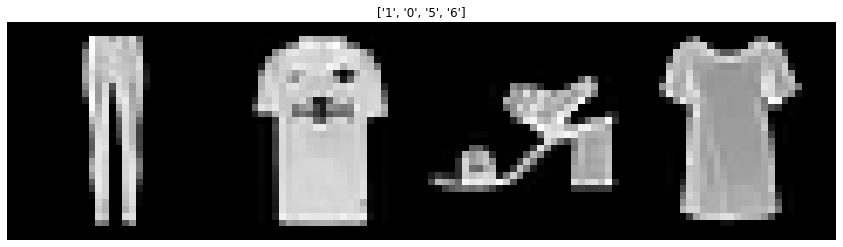

In [ ]:
images, labels = show_batch_images(trainloader)

가장 상위에 표시된 숫자는 클래스를 의미하며 그 내용은 다음과 같습니다.

classes = {
  0: "T-shirt/Top",
  1: "Trouse",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneakers",
  8: "Bag",
  9: "Ankle Boot"
}

이제 모델의 네트워크를 구축합니다.

배치 정규화가 적용된 모델과 비교하기 위해 배치정규화가 적용되지 않는 모델을 먼저 생성해보겠습니다.

In [ ]:
# 배치정규화가 적용되지 않은 모델
class NormalNet(nn.Module):
    def __init__(self): 
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

그 다음에 배치정규화가 포함된 네트워크를 구축합니다.

* 배치정규화 구현 함수

nn.BatchNorm1d()

 -파라미터: 이전 계층의 출력 채널 수
 
 -함수 위치: 완전연결층과 합성곱층 뒤, 활성화 함수 앞 

주어진 빈칸에서 올바른 위치 두 곳을 골라서 배치정규화 함수를 넣어주세요! (세션자료 참고)

In [ ]:
# 배치정규화 적용된 모델
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48), # (입력 크기, 채널 수)
            '''빈칸''',
            nn.ReLU(),
            '''빈칸'''
            nn.Linear(48, 24),
            '''빈칸''',
            nn.ReLU(),
            '''빈칸''',
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# 배치정규화 적용 안 된 모델 출력
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
# 배치정규화 적용된 모델 출력
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


이번에는 학습을 위한 용도로 이미지 데이터셋을 메모리로 불러오겠습니다. 

이 때 배치 크기는 512로 설정합니다.

In [ ]:
'''문제'''
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
# 옵티마이저와 함수 지정
loss_fn = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

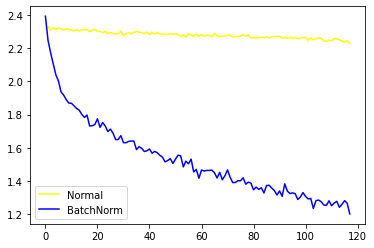

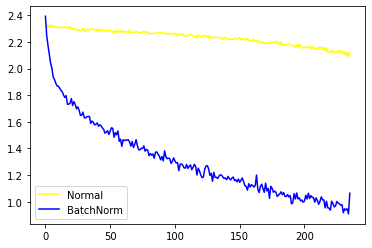

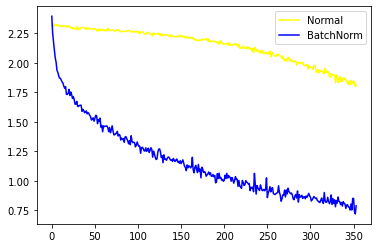

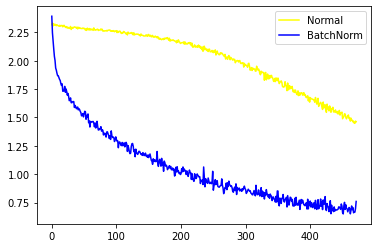

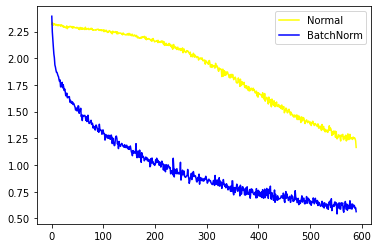

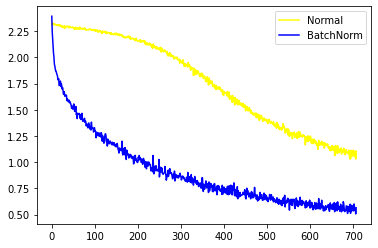

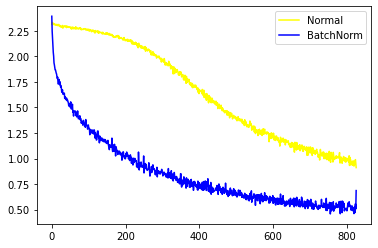

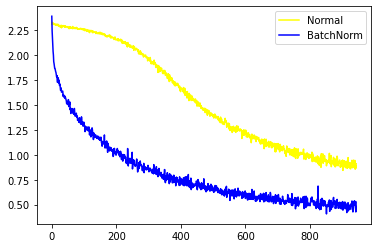

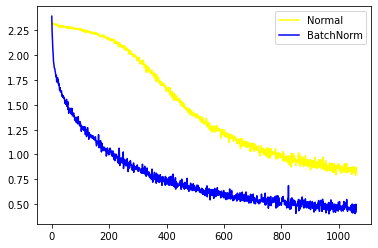

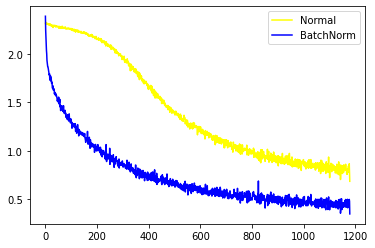

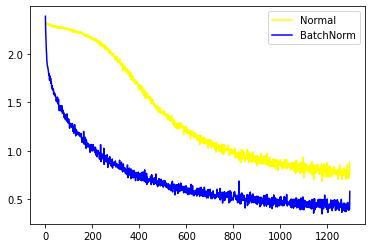

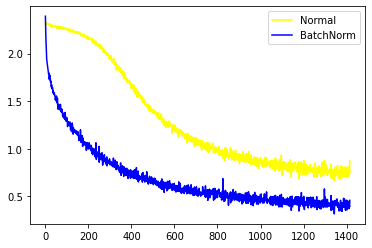

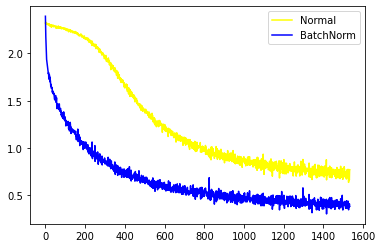

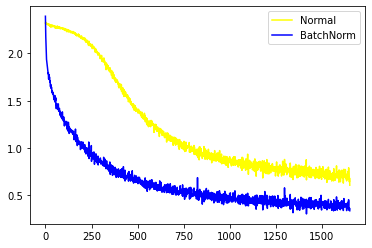

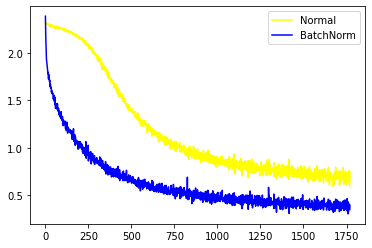

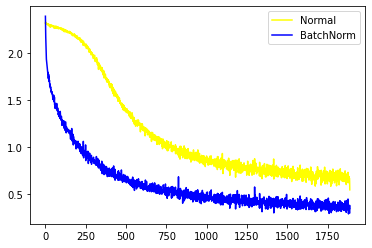

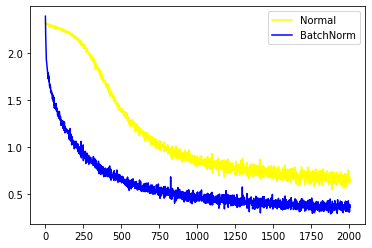

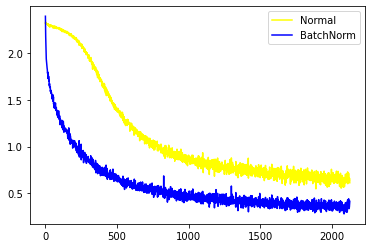

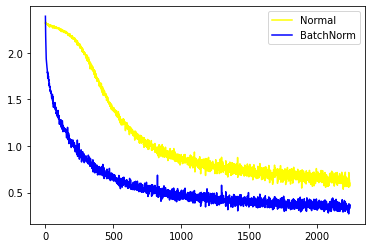

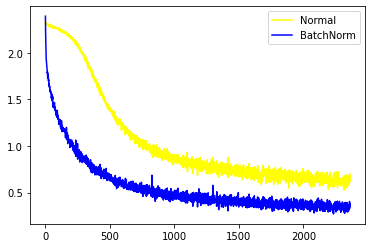

In [ ]:
# 모델 학습
## 배치정규화가 적용된 모델과 적용되지 않은 모델을 그래프로 함께 출력
## 이 때 에포크는 20으로 설정(max_epochs로 지정)
loss_arr = []
loss_bn_arr = []
'''에포크'''

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs).to(device)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
           
    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')    
    plt.legend()
    plt.show()

그래프를 출력해본 결과, 두 모델 모두 시간이 흐를수록 오차가 줄어드는 것을 알 수 있습니다. 

하지만 배치정규화가 적용된 모델이 더 낮은 값으로 안정적인 범위 내에서 줄어들고 있는 것으로 보아, 에포크가 진행될수록 오차도 줄어들면서 안정적인 학습을 하고 있다고 볼 수 있습니다. 

## 2. 드롭아웃

같은 데이터로 진행합니다.

먼저 훈련 세트와 테스트 세트를 전처리하겠습니다.



torch.linspace(): 주어진 범위에서 균등한 값을 갖는 텐서를 만드는 함수

torch.unsqueeze(): 차원을 늘리는 함수

torch.normal: 정규분포로부터 랜덤하게 표본을 추출하는 함수

torch.zeros: 0값을 갖는 N*1 텐서 생성

torch.ones: 1값을 갖는 N*1 텐서 생성

In [ ]:
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1) # -1과 1사이의 값을 갖도록 조정
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
# x_train 과 y_train 설정 방식과 동일하게 진행행
x_test = '''문제''' 
y_test = '''문제'''

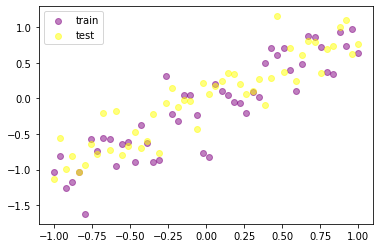

In [ ]:
# 데이터 분포 확인
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

데이터셋의 분포를 확인해본 결과, 훈련 데이터와 테스트 데이터가 고르게 분포되어 있습니다.

이번에도 배치정규화와 마찬가지로 비교를 위해 드롭아웃을 적용한 모델과 적용하지 않은 모델을 생성합니다.

- 드롭아웃 함수

torch.nn.Dropout()

-파라미터: 드롭아웃 비율

드롭아웃을 적용한 모델을 설정할 시, 드롭아웃 비율은 0.2로 설정합니다.

주어진 빈칸 중 적절한 위치 두 곳을 골라 드롭아웃 함수를 입력합니다. (세션자료 참고!)

In [ ]:
N_h = 100
# 드롭아웃을 적용하지 않은 모델
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

# 드롭아웃을 적용한 모델
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    '''빈칸''',
    torch.nn.ReLU(),
    '''빈칸''',
    torch.nn.Linear(N_h, N_h),
    '''빈칸''',
    torch.nn.ReLU(),
    '''빈칸''',
    torch.nn.Linear(N_h, 1),
)

In [ ]:
# 옵티마이저와 손실 함수 지정
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss().to(device)

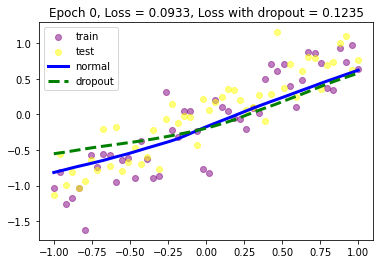

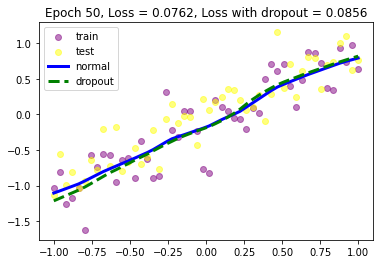

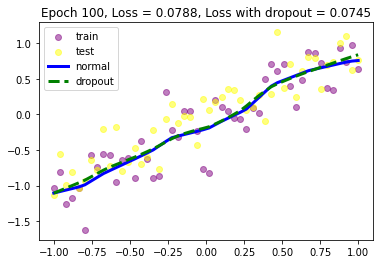

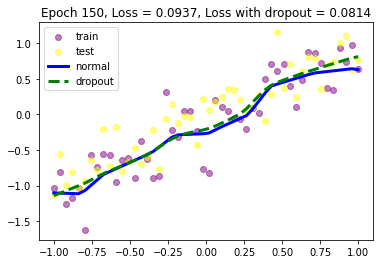

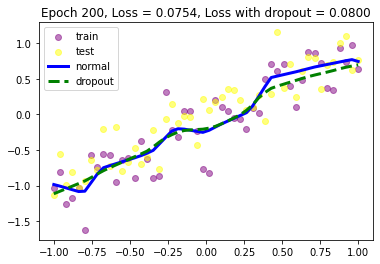

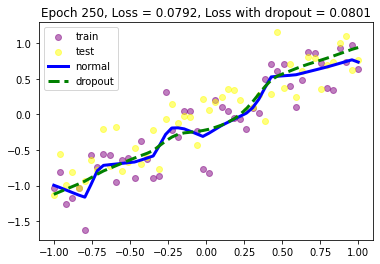

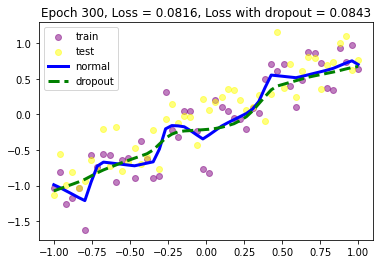

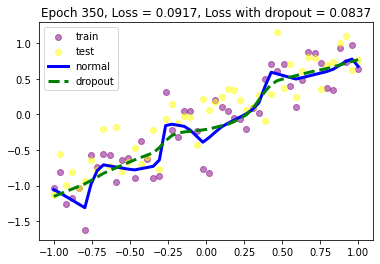

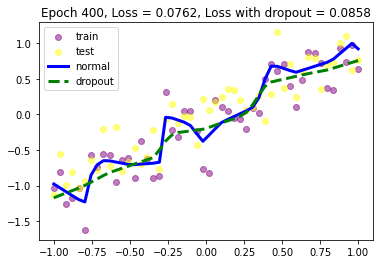

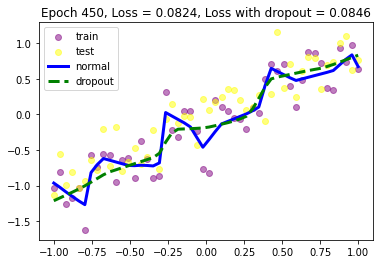

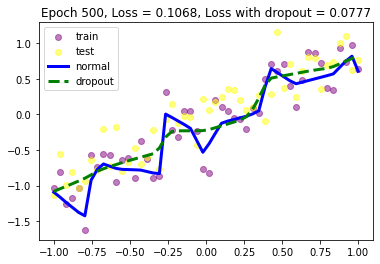

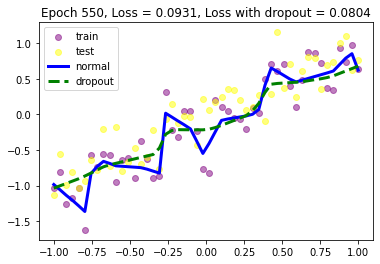

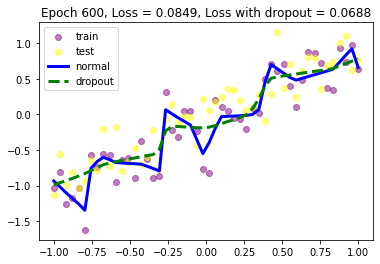

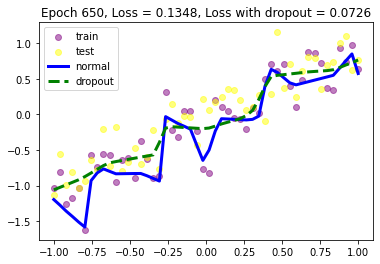

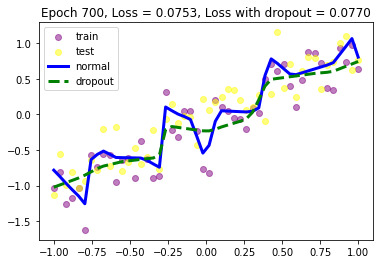

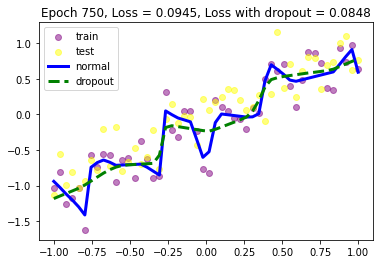

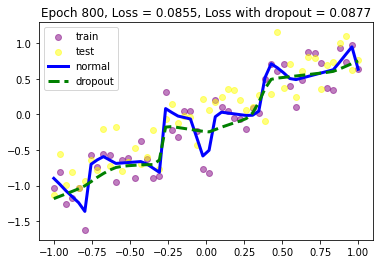

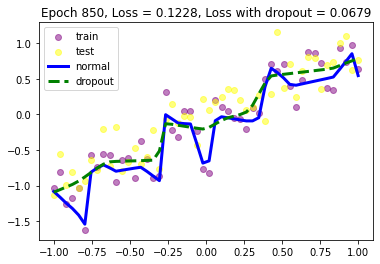

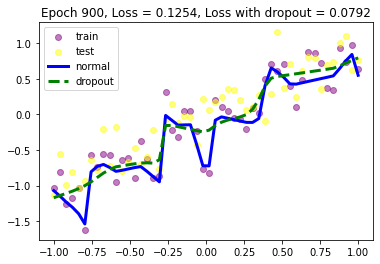

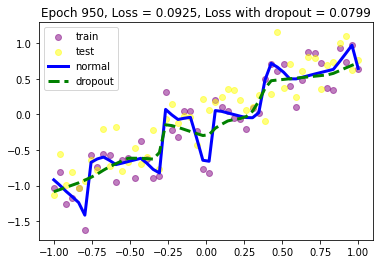

In [ ]:
# 모델 학습
## 에포크 수는 1000으로 설정하여 학습합니다. (max_epochs 로 설정)
'''문제'''
for epoch in range(max_epochs):    
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()    
    
    if epoch % 50 == 0:        
        model.eval()
        model_dropout.eval()
        
        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)
        
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()        
        plt.pause(0.05)

그래프로 확인해본 결과, 오차가 줄어드는 범위가 크지는 않습니다.

다만 드롭아웃을 적용했을 때 오차가 더 낮은 것을 확인할 수 있습니다.

드롭아웃을 적용하지 않은 모델(파란색)의 경우 훈련 데이터셋과 점점 가까워지는데, 이는 오버피팅이 일어났다고 볼 수 있기 때문에 문제가 있습니다. 반면 드롭아웃을 적용한 모델(초록색)의 경우 오버피팅이 일어나지 않고 있기 때문에 오버피팅 방지가 잘 이루어졌다고 볼 수 있습니다.